In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [61]:
trades_1 = pd.read_csv("round5/trades_round_5_day_2.csv", delimiter=';')
trades_2 = pd.read_csv("round5/trades_round_5_day_3.csv", delimiter=';')
trades_2['timestamp'] += 1e6
trades_3 = pd.read_csv("round5/trades_round_5_day_4.csv", delimiter=';')
trades_3['timestamp'] += 2e6

prices_1 = pd.read_csv("round5/prices_round_5_day_2.csv", delimiter=';')
prices_2 = pd.read_csv("round5/prices_round_5_day_3.csv", delimiter=';')
prices_2['timestamp'] += 1e6
prices_3 = pd.read_csv("round5/prices_round_5_day_4.csv", delimiter=';')
prices_3['timestamp'] += 2e6

In [62]:
prices = pd.concat([prices_1, prices_2, prices_3])
trades = pd.concat([trades_1, trades_2, trades_3])

def simple_mid_price(row):
    bid = row[3]
    ask = row[9]
    if np.isnan(bid) and np.isnan(ask):
        return 0
    elif np.isnan(bid):
        return ask
    elif np.isnan(ask):
        return bid
    return (bid+ask) / 2

prices['mid_price'] = prices.apply(simple_mid_price, axis=1)

C:\Users\nirav\AppData\Local\Temp\ipykernel_69660\502764631.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bid = row[3]
C:\Users\nirav\AppData\Local\Temp\ipykernel_69660\502764631.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ask = row[9]


In [63]:
buyers = set(trades['buyer'].unique())
sellers = set(trades['seller'].unique())

print("buyers: ", len(buyers))
print(buyers)
print("sellers: ", len(sellers))
print(sellers)

buyers_and_sellers = set.union(buyers, sellers)
print("buyers and sellers: ", len(buyers_and_sellers))

print(buyers_and_sellers)


buyers:  10
{'Pablo', 'Paris', 'Penelope', 'Peter', 'Olivia', 'Gary', 'Charlie', 'Caesar', 'Camilla', 'Gina'}
sellers:  11
{'Pablo', 'Paris', 'Penelope', 'Peter', 'Olivia', 'Gary', 'Olga', 'Charlie', 'Caesar', 'Camilla', 'Gina'}
buyers and sellers:  11
{'Pablo', 'Paris', 'Olivia', 'Caesar', 'Olga', 'Penelope', 'Peter', 'Gary', 'Charlie', 'Camilla', 'Gina'}


trader:  Pablo
trader:  Paris
trader:  Olivia


KeyboardInterrupt: 

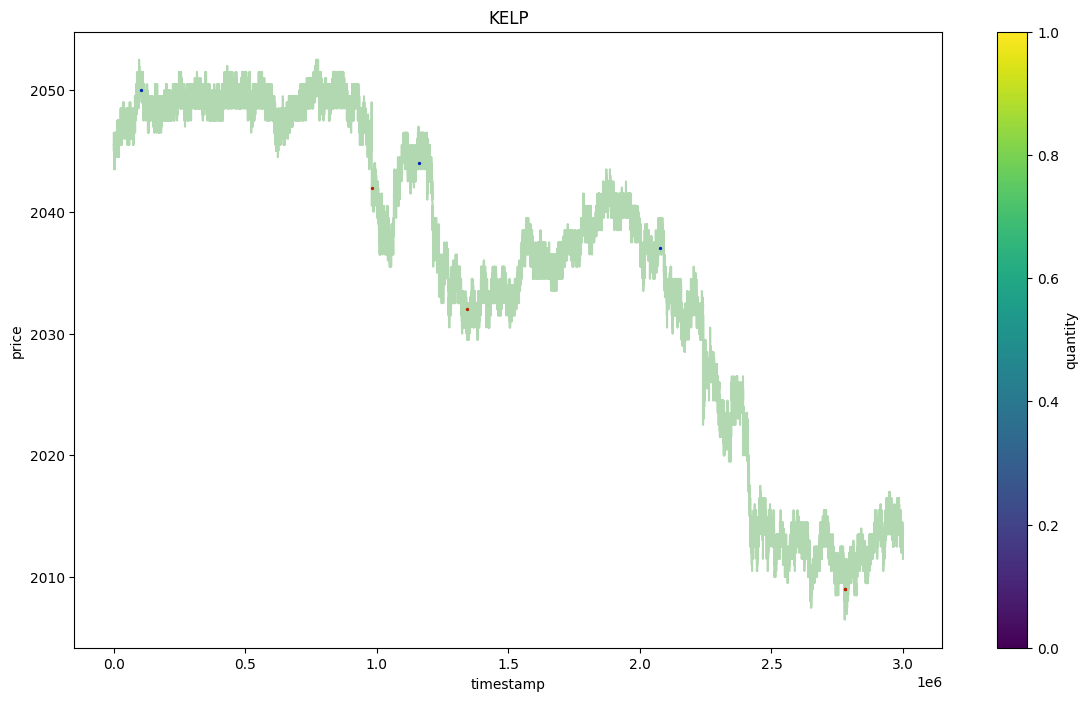

In [64]:
import os
for trader in buyers_and_sellers:
    print("trader: ", trader)

    # when buyer or seller is the trader
    sell_trades_df = trades[(trades['buyer'] == trader)]
    buy_trades_df = trades[(trades['seller'] == trader)]

    products = set.union(set(sell_trades_df['symbol'].unique()), set(buy_trades_df['symbol'].unique()))
    num_products = len(products)


    for i, product in enumerate(products):

        sell_product_trades = sell_trades_df[sell_trades_df['symbol'] == product]
        buy_product_trades = buy_trades_df[buy_trades_df['symbol'] == product]

        price_df = prices[prices['product'] == product]
        plt.figure(figsize=(14, 8))

        # plt.subplot(num_products, 1, i+1)
        plt.title(product)
        plt.plot(price_df['timestamp'], price_df['mid_price'], label='price', c='green', alpha=0.3)

        plt.scatter(sell_product_trades['timestamp'], sell_product_trades['price'], c='Red', label='sell', s=2)
        plt.scatter(buy_product_trades['timestamp'], buy_product_trades['price'], c='Blue', label='buy', s=2)

        plt.colorbar(label='quantity')
        plt.xlabel('timestamp')
        plt.ylabel('price')
        plt.tight_layout()
        os.makedirs(f"trader_plots/{trader}", exist_ok=True)
        plt.savefig(f"trader_plots/{trader}/{product}.png")
        plt.close()

In [ ]:
from tqdm.notebook import tqdm

def backtest_trader(trader, product, trades, prices):
    trader_df = trades[(trades['buyer'] == trader) | (trades['seller'] == trader)]
    trader_df = trader_df[trader_df['symbol'] == product]
    product_prices = prices[prices['product'] == product]

    position = 0
    # start the DCA at the very first mid_price instead of 0
    if not product_prices.empty:
        avg_entry_price = product_prices.iloc[0]['mid_price']
    else:
        avg_entry_price = 0.0
    buy_costs = 0
    sell_costs = 0
    pnls = []
    dcas = []
    timestamps = []
    positions = []

    avg_entry_price = 0.0
    prev_pnl = 0.0

    for row in tqdm(product_prices.itertuples(index=False),
                    total=len(product_prices),
                    desc=f"        {product}",
                    leave=False, position=2):
        time = row.timestamp
        mid_price = row.mid_price

        trades_at_time = trader_df[trader_df['timestamp'] == time]

        for _, trade in trades_at_time.iterrows():
            qty = trade['quantity']
            price = trade['price']

            if trade['buyer'] == trader:
                # Buying
                if position >= 0:
                    # Increase long position
                    total_cost = avg_entry_price * position + price * qty
                    position += qty
                    avg_entry_price = total_cost / position
                else:
                    # Closing short or flipping to long
                    if qty > abs(position):
                        # Flip to long
                        leftover_qty = qty + position
                        avg_entry_price = price  # new long starts fresh
                        position = leftover_qty
                    else:
                        position += qty  # reduce short
                        if position == 0:
                            avg_entry_price = mid_price  # flatten

            elif trade['seller'] == trader:
                # Selling
                if position <= 0:
                    # Increase short position
                    total_cost = avg_entry_price * abs(position) + price * qty
                    position -= qty
                    avg_entry_price = total_cost / abs(position)
                else:
                    # Closing long or flipping to short
                    if qty > position:
                        # Flip to short
                        leftover_qty = qty - position
                        avg_entry_price = price  # new short starts fresh
                        position = -leftover_qty
                    else:
                        position -= qty  # reduce long
                        if position == 0:
                            avg_entry_price = mid_price  # flatten

        # Calculate PnL
        if position > 0:
            pnl = (mid_price - avg_entry_price) * position
        elif position < 0:
            pnl = (avg_entry_price - mid_price) * abs(position)
        else:
            pnl = 0

        pnl += prev_pnl

        pnls.append(pnl)
        dcas.append(avg_entry_price)
        timestamps.append(time)
        positions.append(position)

        if time % 1e6 == 0:
            prev_pnl = pnl
            position = 0
            avg_entry_price = mid_price

    return pnls, timestamps, positions, dcas



In [66]:
import numpy as np
import matplotlib.pyplot as plt

def plot_trader_dca_signals(trader, product, trades, prices):
    # backtest gives us PnL, timestamps, positions, dcas
    pnls, timestamps, positions, dcas = backtest_trader(trader, product, trades, prices)

    # extract buys/sells for arrow overlays
    trader_df = trades[(trades['buyer']==trader) | (trades['seller']==trader)]
    tdf = trader_df[trader_df['symbol']==product]
    buy_df  = tdf[tdf['buyer']==trader]
    sell_df = tdf[tdf['seller']==trader]

    price_df = prices[prices['product']==product]

    fig, (ax0, ax1) = plt.subplots(2,1,sharex=True, figsize=(14,10), gridspec_kw={'height_ratios':[2,1]})

    # --- panel 0: DCA vs Mid Price + long/short shading + signals ---
    # shading
    ts = np.array(timestamps)
    pos = np.array(positions)
    ymin, ymax = price_df['mid_price'].min()*0.9, price_df['mid_price'].max()*1.1

    ax0.fill_between(ts, ymin, ymax, where=pos>0, facecolor='green',  alpha=0.1, label='Long Region')
    ax0.fill_between(ts, ymin, ymax, where=pos<0, facecolor='red',    alpha=0.1, label='Short Region')

    # mid price
    ax0.plot(price_df['timestamp'], price_df['mid_price'],
             c='purple', linewidth=1, alpha=0.7, label='Mid Price')

    # DCA
    ax0.plot(timestamps, dcas,
             c='orange', linewidth=2, label='Dollar Cost Avg')

    # buy/sell arrows
    # up-arrows for buys
    ax0.scatter(
        buy_df['timestamp'], buy_df['price'],
        marker='^', s=30, c='green', alpha=0.6, label='Buy Signal'
    )
    # down-arrows for sells
    ax0.scatter(
        sell_df['timestamp'], sell_df['price'],
        marker='v', s=30, c='red', alpha=0.6, label='Sell Signal'
    )

    ax0.set_title(f"{trader} DCA vs Mid Price & Signals for {product}")
    ax0.set_ylabel("Price")
    ax0.legend(loc='upper left')
    ax0.grid(True)

    # --- panel 1: PnL & Position Size ---
    ax1.plot(timestamps, pnls,
             c='blue', linewidth=1, label='PnL')
    ax1.set_ylabel("PnL", color='blue')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(timestamps, positions,
             c='red', linewidth=1, alpha=0.7, label='Position Size')
    ax2.set_ylabel("Position Size", color='red')

    ax1.set_title(f"{trader} PnL & Position for {product}")
    ax1.set_xlabel("Timestamp")

    # merge legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines+lines2, labels+labels2, loc='upper left')

    plt.tight_layout()
    os.makedirs(f"product_plots/{product}", exist_ok=True)
    plt.savefig(f"product_plots/{product}/{trader}.png")
    plt.close()

In [85]:
# Usage:
from tqdm.notebook import tqdm
for trader in tqdm(buyers_and_sellers, desc=f"Generating", position=0):
    # when buyer or seller is the trader
    sell_trades_df = trades[(trades['buyer'] == trader)]
    buy_trades_df = trades[(trades['seller'] == trader)]

    products = set.union(set(sell_trades_df['symbol'].unique()), set(buy_trades_df['symbol'].unique()))

    for product in tqdm(products, desc=f"    {trader}", leave=False, position=1):
        plot_trader_dca_signals(trader, product, trades, prices)

Generating:   0%|          | 0/11 [00:00<?, ?it/s]

    Pablo:   0%|          | 0/11 [00:00<?, ?it/s]

        PICNIC_BASKET2:   0%|          | 0/30000 [00:00<?, ?it/s]

        VOLCANIC_ROCK_VOUCHER_10000:   0%|          | 0/30000 [00:00<?, ?it/s]

        VOLCANIC_ROCK_VOUCHER_10500:   0%|          | 0/30000 [00:00<?, ?it/s]

        RAINFOREST_RESIN:   0%|          | 0/30000 [00:00<?, ?it/s]

        KELP:   0%|          | 0/30000 [00:00<?, ?it/s]

        PICNIC_BASKET1:   0%|          | 0/30000 [00:00<?, ?it/s]

        SQUID_INK:   0%|          | 0/30000 [00:00<?, ?it/s]

        VOLCANIC_ROCK:   0%|          | 0/30000 [00:00<?, ?it/s]

        VOLCANIC_ROCK_VOUCHER_9500:   0%|          | 0/30000 [00:00<?, ?it/s]

        VOLCANIC_ROCK_VOUCHER_9750:   0%|          | 0/30000 [00:00<?, ?it/s]

        VOLCANIC_ROCK_VOUCHER_10250:   0%|          | 0/30000 [00:00<?, ?it/s]

    Paris:   0%|          | 0/7 [00:00<?, ?it/s]

        CROISSANTS:   0%|          | 0/30000 [00:00<?, ?it/s]

        SQUID_INK:   0%|          | 0/30000 [00:00<?, ?it/s]

        MAGNIFICENT_MACARONS:   0%|          | 0/30000 [00:00<?, ?it/s]

        DJEMBES:   0%|          | 0/30000 [00:00<?, ?it/s]

        RAINFOREST_RESIN:   0%|          | 0/30000 [00:00<?, ?it/s]

        JAMS:   0%|          | 0/30000 [00:00<?, ?it/s]

        KELP:   0%|          | 0/30000 [00:00<?, ?it/s]

    Olivia:   0%|          | 0/3 [00:00<?, ?it/s]

        CROISSANTS:   0%|          | 0/30000 [00:00<?, ?it/s]

        SQUID_INK:   0%|          | 0/30000 [00:00<?, ?it/s]

        KELP:   0%|          | 0/30000 [00:00<?, ?it/s]

    Caesar:   0%|          | 0/15 [00:00<?, ?it/s]

        CROISSANTS:   0%|          | 0/30000 [00:00<?, ?it/s]

        MAGNIFICENT_MACARONS:   0%|          | 0/30000 [00:00<?, ?it/s]

        DJEMBES:   0%|          | 0/30000 [00:00<?, ?it/s]

        VOLCANIC_ROCK_VOUCHER_10000:   0%|          | 0/30000 [00:00<?, ?it/s]

        VOLCANIC_ROCK_VOUCHER_10500:   0%|          | 0/30000 [00:00<?, ?it/s]

        PICNIC_BASKET2:   0%|          | 0/30000 [00:00<?, ?it/s]

        JAMS:   0%|          | 0/30000 [00:00<?, ?it/s]

        RAINFOREST_RESIN:   0%|          | 0/30000 [00:00<?, ?it/s]

        KELP:   0%|          | 0/30000 [00:00<?, ?it/s]

        PICNIC_BASKET1:   0%|          | 0/30000 [00:00<?, ?it/s]

        SQUID_INK:   0%|          | 0/30000 [00:00<?, ?it/s]

        VOLCANIC_ROCK_VOUCHER_9500:   0%|          | 0/30000 [00:00<?, ?it/s]

        VOLCANIC_ROCK:   0%|          | 0/30000 [00:00<?, ?it/s]

        VOLCANIC_ROCK_VOUCHER_9750:   0%|          | 0/30000 [00:00<?, ?it/s]

        VOLCANIC_ROCK_VOUCHER_10250:   0%|          | 0/30000 [00:00<?, ?it/s]

    Olga:   0%|          | 0/1 [00:00<?, ?it/s]

        KELP:   0%|          | 0/30000 [00:00<?, ?it/s]

    Penelope:   0%|          | 0/10 [00:00<?, ?it/s]

        PICNIC_BASKET2:   0%|          | 0/30000 [00:00<?, ?it/s]

        VOLCANIC_ROCK_VOUCHER_10000:   0%|          | 0/30000 [00:00<?, ?it/s]

        VOLCANIC_ROCK_VOUCHER_10500:   0%|          | 0/30000 [00:00<?, ?it/s]

        RAINFOREST_RESIN:   0%|          | 0/30000 [00:00<?, ?it/s]

        KELP:   0%|          | 0/30000 [00:00<?, ?it/s]

        PICNIC_BASKET1:   0%|          | 0/30000 [00:00<?, ?it/s]

        SQUID_INK:   0%|          | 0/30000 [00:00<?, ?it/s]

        VOLCANIC_ROCK_VOUCHER_9500:   0%|          | 0/30000 [00:00<?, ?it/s]

        VOLCANIC_ROCK_VOUCHER_9750:   0%|          | 0/30000 [00:00<?, ?it/s]

        VOLCANIC_ROCK_VOUCHER_10250:   0%|          | 0/30000 [00:00<?, ?it/s]

    Peter:   0%|          | 0/1 [00:00<?, ?it/s]

        VOLCANIC_ROCK:   0%|          | 0/30000 [00:00<?, ?it/s]

    Gary:   0%|          | 0/3 [00:00<?, ?it/s]

        SQUID_INK:   0%|          | 0/30000 [00:00<?, ?it/s]

        RAINFOREST_RESIN:   0%|          | 0/30000 [00:00<?, ?it/s]

        KELP:   0%|          | 0/30000 [00:00<?, ?it/s]

    Charlie:   0%|          | 0/6 [00:00<?, ?it/s]

        PICNIC_BASKET1:   0%|          | 0/30000 [00:00<?, ?it/s]

        SQUID_INK:   0%|          | 0/30000 [00:00<?, ?it/s]

        MAGNIFICENT_MACARONS:   0%|          | 0/30000 [00:00<?, ?it/s]

        PICNIC_BASKET2:   0%|          | 0/30000 [00:00<?, ?it/s]

        RAINFOREST_RESIN:   0%|          | 0/30000 [00:00<?, ?it/s]

        KELP:   0%|          | 0/30000 [00:00<?, ?it/s]

    Camilla:   0%|          | 0/14 [00:00<?, ?it/s]

        CROISSANTS:   0%|          | 0/30000 [00:00<?, ?it/s]

        MAGNIFICENT_MACARONS:   0%|          | 0/30000 [00:00<?, ?it/s]

        PICNIC_BASKET2:   0%|          | 0/30000 [00:00<?, ?it/s]

        VOLCANIC_ROCK_VOUCHER_10000:   0%|          | 0/30000 [00:00<?, ?it/s]

        VOLCANIC_ROCK_VOUCHER_10500:   0%|          | 0/30000 [00:00<?, ?it/s]

        DJEMBES:   0%|          | 0/30000 [00:00<?, ?it/s]

        VOLCANIC_ROCK_VOUCHER_10250:   0%|          | 0/30000 [00:00<?, ?it/s]

        RAINFOREST_RESIN:   0%|          | 0/30000 [00:00<?, ?it/s]

        KELP:   0%|          | 0/30000 [00:00<?, ?it/s]

        PICNIC_BASKET1:   0%|          | 0/30000 [00:00<?, ?it/s]

        SQUID_INK:   0%|          | 0/30000 [00:00<?, ?it/s]

        VOLCANIC_ROCK_VOUCHER_9500:   0%|          | 0/30000 [00:00<?, ?it/s]

        VOLCANIC_ROCK_VOUCHER_9750:   0%|          | 0/30000 [00:00<?, ?it/s]

        JAMS:   0%|          | 0/30000 [00:00<?, ?it/s]

    Gina:   0%|          | 0/3 [00:00<?, ?it/s]

        SQUID_INK:   0%|          | 0/30000 [00:00<?, ?it/s]

        RAINFOREST_RESIN:   0%|          | 0/30000 [00:00<?, ?it/s]

        KELP:   0%|          | 0/30000 [00:00<?, ?it/s]

Notes:
- Olivia is a signal for tops/bottoms on squid ink, kelp, and croissants